# How to use Voyage AI embeddings and rerankers with MongoDB Atlas Vector Search.

This notebook provides an example of a two-stage retrieval system using the Voyage [voyage-law-2](https://blog.voyageai.com/2024/04/15/domain-specific-embeddings-and-retrieval-legal-edition-voyage-law-2/) embedding model, Voyage [rerank-2](https://blog.voyageai.com/2024/09/30/rerank-2/) reranker, and [MongoDB Atlas](https://www.mongodb.com/atlas) to implement semantic search and retrieval of relevant contract chunks from the [MTEB LegalBench Consumer Contracts QA dataset](https://huggingface.co/datasets/mteb/legalbench_consumer_contracts_qa). This is illustrated in the following figure.

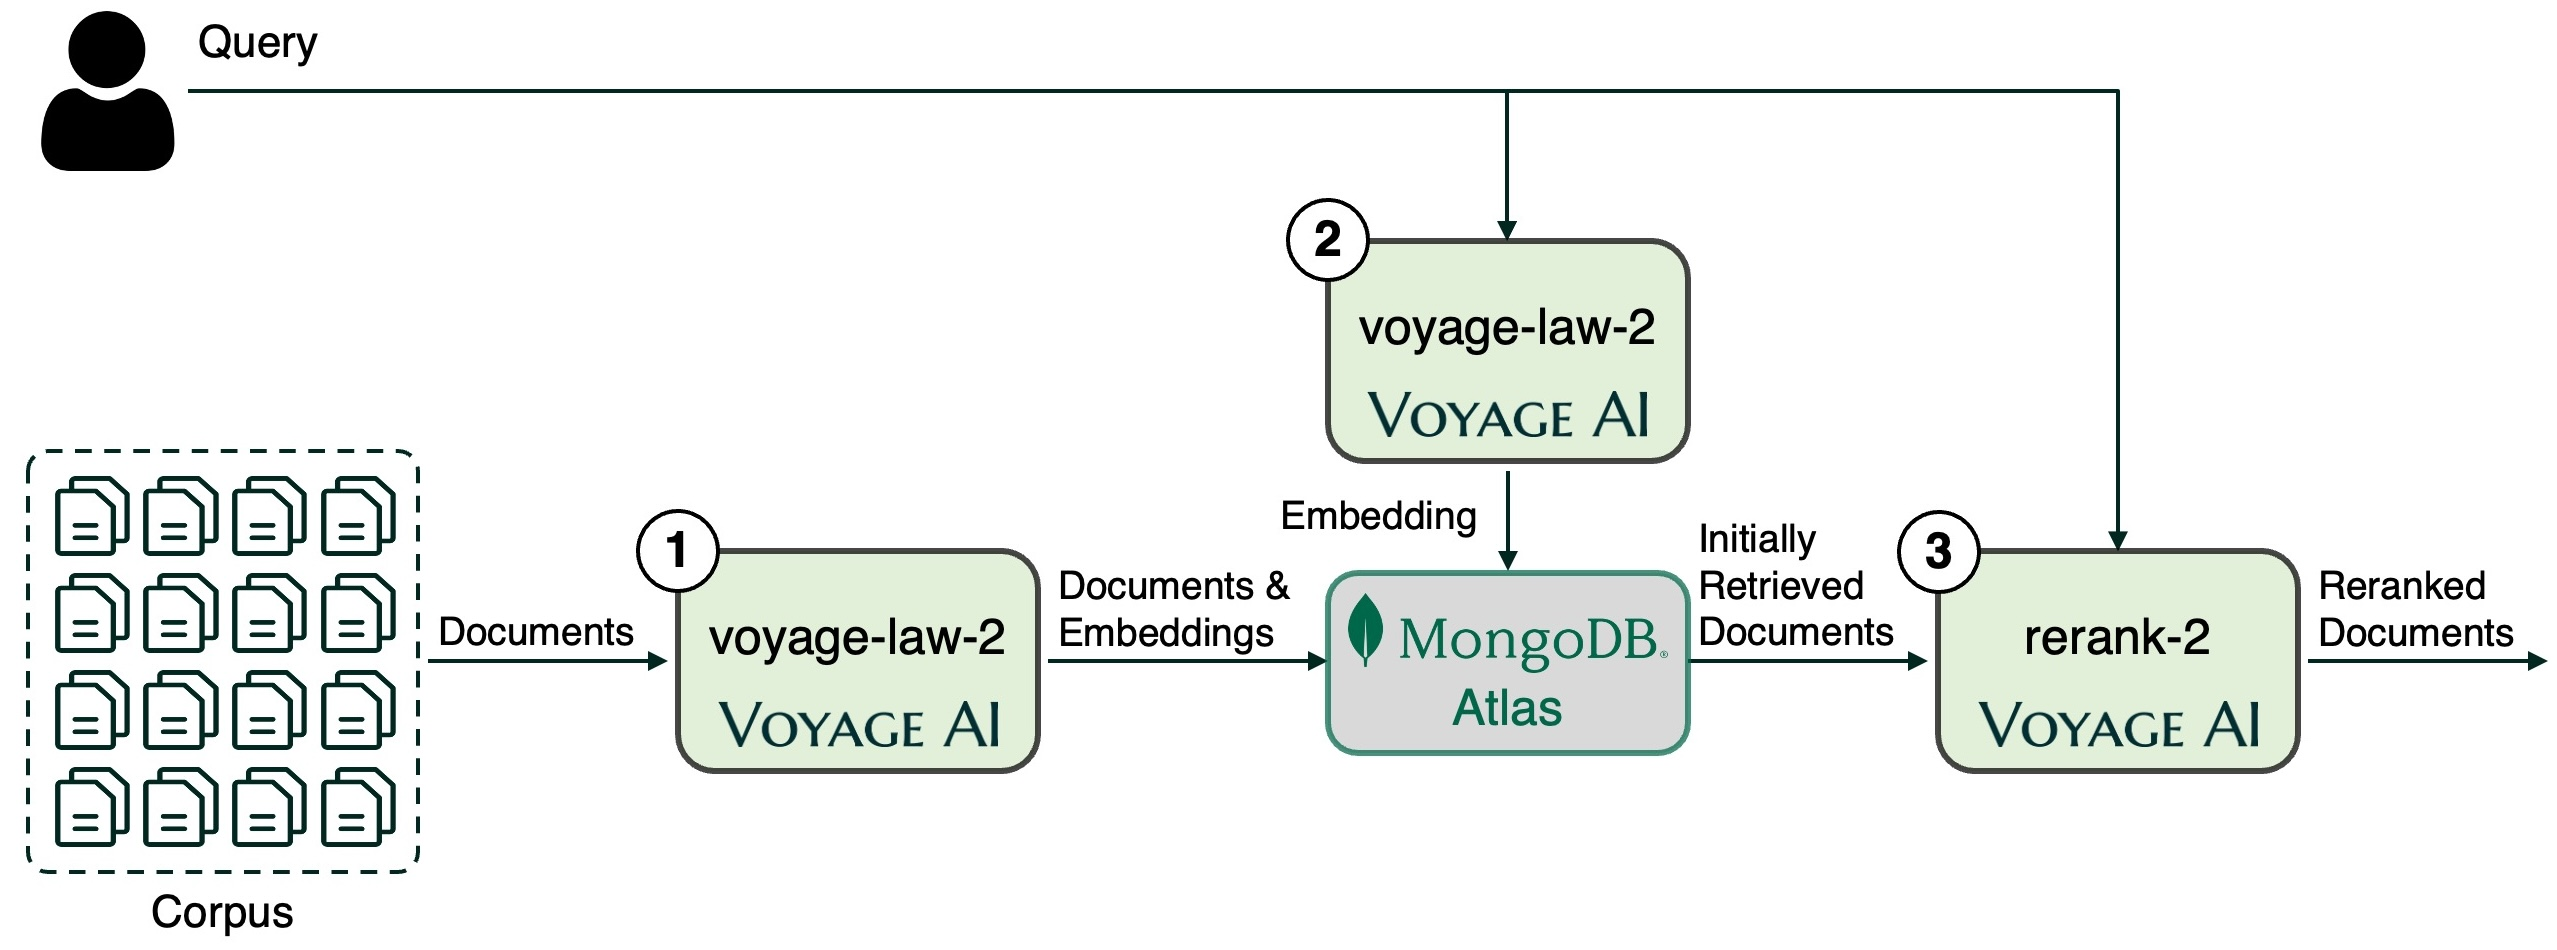

We explain each numbered step shown in the figure above. The heading of each step links directly to the corresponding section of the notebook that executes it

1. **[Create and store embeddings for semantic search](#3-Create-and-store-embeddings-for-semantic-search)**. We will create vector embeddings on the LegalBench Consumer Contracts QA dataset using `voyage-law-2` and store and index those embeddings in MongoDB Atlas.

   Legal retrieval is a labor-intensive, yet crucial task of any legal firm. But, high-quality legal retrieval is especially challenging due to dense jargon and extensive length of legal documents. Domain customization solves these challenges by allocating embedding model parameters to specialized legal knowledge, enabling high-quality performance while meeting latency constraints. `voyage-law-2` is a cutting-edge embedding model optimized for legal retrieval. Since its release over six months ago, it has been at the top [MTEB leaderboard for legal retrieval](https://huggingface.co/spaces/mteb/leaderboard?task=retrieval&language=law), outperforming OpenAI v3 large by 6% on average over eight legal retrieval datasets and by more than 10% on three of them ([LeCaRDv2](https://huggingface.co/datasets/mteb/LeCaRDv2), [LegalQuAD](https://huggingface.co/datasets/mteb/LegalQuAD), and [GerDaLIR](https://huggingface.co/datasets/mteb/GerDaLIR)).

2. **[Retrieve relevant documents from index](#4-Retrieve-relevant-documents-from-index)**. We will vectorize a query and retrieve the most relevant documents (via the vector embeddings) from MongoDB Atlas.

3. **[Refine initial retrieval with reranking](#5-Refine-initial-retrieval-with-reranking)**. We will refine our initial retrieval with `rerank-2`.

   Rerankers boost the quality of retrieval systems by refining the order of the initial search results. `rerank-2` is Voyage's latest cutting-edge generalist reranker optimzied for quality with multilingual support. When evaluated across 93 retrieval datasets spanning multiple domains, adding `rerank-2` on top of OpenAI’s latest embedding model (v3 large) improves the accuracy by an average of 13.89%, 2.3x the improvement attained by the latest Cohere reranker (English v3). Furthermore, rerank-2 support context lengths of 16K, which is 4x the context length of Cohere’s reranker.

# 1 Prerequisites

You need the following prerequisites to properly run this notebook.
1. [Register](https://docs.voyageai.com/docs/api-key-and-installation#authentication-with-api-keys) for a Voyage AI account and obtain a Voyage AI API key.
2. Create a MongoDB Atlas cluster and user. You can follow this [tutorial]( https://www.mongodb.com/resources/products/fundamentals/create-database).

# 2 Configurations

## 2.1 Install and import required packages

In [1]:
# Remove any notices of pip upgrades
import os
os.environ['PIP_NO_WARN_SCRIPT_LOCATION'] = 'false'
os.environ['PIP_DISABLE_PIP_VERSION_CHECK'] = 'true'

In [2]:
!pip install -qU datasets # Hugging Face Datasets package to load datasets from the Hugging Face Hub
!pip install -qU voyageai # Voyage AI Python client
!pip install -qU pymongo # MongoDB Python client
!pip install -qU python-dotenv
!pip install -qU pandas # Data processing and handling for results
!pip install -qU tqdm # For progress bar

In [1]:
import pandas as pd
import getpass
import copy
import pprint
pp1 = pprint.PrettyPrinter(indent=2, width=80, compact=True, depth=1)

# Load environment variables
from dotenv import load_dotenv
load_dotenv()

True

# A step-by-step guide to create a new cluster in MongoDB Atlas and get the connection string:

### Step 1: Sign In to MongoDB Atlas
* Go to the [`MongoDB Atlas website`](https://www.mongodb.com/products/platform/cloud).

* Sign in with your MongoDB account. If you don’t have an account, you can create one for free.

### Step 2: Create a New Cluster
* Once signed in, navigate to the Clusters page.

* Click on the Build a New Cluster button.

* Choose your cloud provider (AWS, Google Cloud, or Azure) and the region closest to your users.

* Select the cluster tier. M10 option.

* Click Create Cluster and wait for your cluster to be provisioned. This may take a few minutes.

### Step 3: Configure Your Cluster
* After the cluster is created, you can configure additional settings such as backup options, security settings, and more.

* Add your IP address to the IP Whitelist to allow access to the cluster.

### Step 4: Create a Database User
* Go to the Database Access tab.

* Click on Add New Database User.

* Enter a username and password for the new user.

* Assign the user appropriate roles and permissions.

* Click Add User.

### Step 5: Get the Connection String
* Go back to the Clusters page.

* Click on the Connect button for your cluster.

* Choose the connection method (e.g., MongoDB Compass, MongoDB Shell, or your application).

* Copy the connection string provided.

* And there you have it! Your new MongoDB Atlas cluster is set up, and you have the connection string to start using it. If you need more detailed instructions, you can refer to the official [`MongoDB documentation`](https://www.mongodb.com/docs/guides/atlas/connection-string/).

This notebook assumes that sensitive information, like credentials, are specified in an `.env` file and can be loaded as environment variables (see [`python-dotenv`](https://pypi.org/project/python-dotenv/)). However, if the environment variables are not set, you can set them in the notebook or you will be prompted to enter them in a secure way. The expected environment variables are:

* `VOYAGE_API_KEY`: Voyage AI API Key
* `MONGODB_CONNECTION_STR`: MongoDB Atlas Connection String

## 2.2 Load LegalBench Consumer Contracts QA Dataset from HuggingFace

The [MTEB LegalBench Consumer Contracts QA dataset](https://huggingface.co/datasets/mteb/legalbench_consumer_contracts_qa) includes questions and answers related to contracts. The corpus set consists of the contracts and the query set comprises the questions about the contracts. For each query, the dataset does identify the ground truth relevant document.

In [2]:
# Load the dataset from Hugging Face
import datasets
dataset = datasets.load_dataset("mteb/legalbench_consumer_contracts_qa", "corpus")

/Users/ashwin.gangadhar/base/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Create a corpus of documents with the document IDs
corpus = [{"id": record['_id'], "text": record['text']} for record in dataset["corpus"]]

In [4]:
# See the number of documents in the dataset and print out the first three samples.
print("Number of documents: " + str(len(corpus)))
print("\nSample Documents:")
for i in range(3):
    print(f'ID: {corpus[i]['id']}, "{corpus[i]['text'][0:80].replace("\n", "\\n")}..."')

Number of documents: 154

Sample Documents:
ID: 9NIQ0Wobtq, "Your content\nSome of our services give you the opportunity to make your content ..."
ID: 3npgW2zMj5, "Google content\nSome of our services include content that belongs to Google  for ..."
ID: P9K63LSFZH, "Settling disputes, governing law and courts\n\nFor information about how to contac..."


## 2.3 Initialize MongoDB Atlas connection string

The connection string will allow us to securely connect to our MongoDB Atlas instance.

In [7]:
import os
# Set MongoDB Atlas Connection String
try:
    MONGODB_URI = os.environ["MONGODB_CONNECTION_STR"]
except KeyError:
    MONGODB_URI = getpass.getpass("Please enter your MongoDB Atlas connection string (hit enter): ")

## 2.4 Initialize Voyage API key

The Voyage API key will allow us to access the `voyage-law-2` hosted API endpoint to generate embeddings.

In [8]:
try:
    VOYAGE_API_KEY = os.environ["VOYAGE_API_KEY"]
except KeyError:
    VOYAGE_API_KEY = getpass.getpass("Please enter your Voyage AI API KEY (hit enter): ")

# 3 Create and store embeddings for semantic search

## 3.1 Create vector embeddings

In [10]:
# Initialize the Voyage Python client
import voyageai  
vo_client = voyageai.Client(VOYAGE_API_KEY)

We can now vectorize the documents in our corpus, and to optimize efficiency, it's best to submit requests in batches. For our document chunks and embedding model, we've set the batch size below to the maximum of 128.

In practice, you may need to adjust this. Each model has performance and infrastructure limits, including a maximum number of documents and tokens per request. For instance, the `voyage-law-2` model supports up to 128 documents per batch, with a total token limit of 120K per request.

In [23]:
# Set batch size
BATCH_SIZE = 128

The following step will vectorize the corpus using the Voyage hosted API endpoint. It may take a few seconds.

In [25]:
# Vectorize the corpus
from tqdm import tqdm 
embeddings = []

for i in tqdm(range(0, len(corpus), BATCH_SIZE), desc="Vectorizing corpus"):
    embeddings += vo_client.embed(
        [record['text'] for record in corpus[i:i + BATCH_SIZE]], model="voyage-law-2", input_type="document"
    ).embeddings

Vectorizing corpus: 100%|██████████| 2/2 [00:18<00:00,  9.01s/it]


In [26]:
# Print vector dimension
EMBED_DIMENSION = len(embeddings[0])
print("Embedding Dimension: " + str(EMBED_DIMENSION))

Embedding Dimension: 1024


In [27]:
# Prepare records to insert into Atlas collection
legalbench_collection_records = [{"doc_id": doc['id'], "text": doc['text'], "embedding": embedding} for doc, embedding in zip(corpus, embeddings)]

In [28]:
# Print an example record
print("Example embedding record:\n")
pp1.pprint(legalbench_collection_records[0])

Example embedding record:

{ 'doc_id': '9NIQ0Wobtq',
  'embedding': [...],
  'text': 'Your content\n'
          'Some of our services give you the opportunity to make your content '
          'publicly available  for example, you might post a product or '
          'restaurant review that you wrote, or you might upload a blog post '
          'that you created.\n'
          'See the Permission to use your content section for more about your '
          'rights in your content, and how your content is used in our '
          'services\n'
          'See the Removing your content section to learn why and how we might '
          'remove user-generated content from our services\n'
          'If you think that someone is infringing your intellectual property '
          'rights, you can send us notice of the infringement and well take '
          'appropriate action. For example, we suspend or close the Google '
          'Accounts of repeat copyright infringers as described in our '
      

## 3.2 Initialize Atlas and insert embedding records into Atlas collection

In [29]:
from pymongo import MongoClient
mongo_client = MongoClient(MONGODB_URI, tlsInsecure=True)

In [30]:
# List existing databases in Atlas
mongo_client.list_database_names()

['Weather-station',
 'admin',
 'amazon',
 'arcee-mdb',
 'chatter',
 'config',
 'db',
 'ibm',
 'langchain-test',
 'local',
 'maap-test',
 'sample',
 'sample_movies',
 'search',
 'test-2',
 'test2',
 'testdatabricks',
 'testdb']

In [31]:
# We'll use the `sample_mflix` database
db = mongo_client["sample_mflix"]

In [32]:
# Create a `legalbench` collection (drop if there is an existing one)
if "legalbench" in db.list_collection_names():
    db.drop_collection("legalbench")

db.create_collection("legalbench")
legalbench_collection = db["legalbench"]

In [33]:
# Insert our records into the `legalbench` collection
e = legalbench_collection.insert_many(legalbench_collection_records)
if legalbench_collection.count_documents({}) == len(legalbench_collection_records):
    print("All records inserted successfully.")

All records inserted successfully.


In [34]:
# Print a record from the `legalbench` collection
print("Example Atlas legalbench collection record:\n")
pp1.pprint(legalbench_collection.find_one())

Example Atlas legalbench collection record:

{ '_id': ObjectId('67346d595f30638b199022b4'),
  'doc_id': '9NIQ0Wobtq',
  'embedding': [...],
  'text': 'Your content\n'
          'Some of our services give you the opportunity to make your content '
          'publicly available  for example, you might post a product or '
          'restaurant review that you wrote, or you might upload a blog post '
          'that you created.\n'
          'See the Permission to use your content section for more about your '
          'rights in your content, and how your content is used in our '
          'services\n'
          'See the Removing your content section to learn why and how we might '
          'remove user-generated content from our services\n'
          'If you think that someone is infringing your intellectual property '
          'rights, you can send us notice of the infringement and well take '
          'appropriate action. For example, we suspend or close the Google '
          'Acc

## 3.3 Create vector search index in Atlas

The following code creates a vector search index named `legalbench_vectors` by indexing the `embedding` field.  The index is configured to use cosine similarity to search for the top K nearest neighbors.  You can get more help on how to index fields for vector search in Atlas [here](https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-type/).

In [38]:
# Create a vector search index on the `legalbench` collection
from pymongo.operations import SearchIndexModel

legalbench_collection.create_search_index(
    SearchIndexModel(
        name="legalbench_vectors",
        type="vectorSearch",
        definition={
            "fields": [
                {
                    "path": "embedding",
                    "type": "vector",
                    "numDimensions": EMBED_DIMENSION,
                    "similarity": "cosine"
                }
            ]
        }
    )
)

'legalbench_vectors'

In [46]:
def get_index_config(index_name):
    idxs = list(legalbench_collection.list_search_indexes())
    for ele in idxs:
        if ele["name"]==index_name:
            return ele
while True: 
    idx = get_index_config("legalbench_vectors")
    if idx["queryable"]:
        print("Vector search index created successfully.")
    break

Vector search index created successfully.


# 4 Retrieve relevant documents from index

## 4.1 Vectorize the query

In [47]:
# Query
query = "If I think that some content on the platform doesnt comply with the terms, is it enough that I describe the content, provide a link and provide my full personal details?"
print(f'Query: {query}')

Query: If I think that some content on the platform doesnt comply with the terms, is it enough that I describe the content, provide a link and provide my full personal details?


In [48]:
# Identify ground truth relevant record
relevant_record = next((record for record in corpus if record['id'] == "8IRh1E2JDB"), None)
print(f'Relevant doc ID: {relevant_record['id']})\n\n{relevant_record['text']}')

Relevant doc ID: 8IRh1E2JDB)

OUR PROPERTY
The Service is protected by copyright, trademark, and other US and foreign laws. These AUP Guidelines dont grant you any right, title, or interest in the Service or others content in the Service. We welcome feedback, but note that we may use comments or suggestions without any obligation to you.

INFRINGEMENT
We respect the intellectual property of others and ask that you do too. We respond to notices of alleged infringement after receipt of a proper notice that complies with the law and is received by our designated agent. We reserve the right to delete or disable content alleged to be infringing and terminate accounts of repeat infringers. If you believe that any content in the Service in a way that constitutes infringement, please provide our designated agent with the following information:
1. an electronic or physical signature of the person authorized to act on behalf of the rights owner;
2. a description of the content you claim is being

We know the ground truth document containing the answer to this query in our corpus is document ID 8IRh1E2JDB.

In [49]:
# Vectorize the query
query_result = vo_client.embed(
    texts=query,
    model="voyage-law-2",
    input_type="query"
)

query_vector = query_result.embeddings[0]

## 4.2 Retrieve relevant documents from Atlas vector search index

The following code performs an approximate nearest neighbor ([ANN](https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-stage/#ann-search)) search against our query vector (`query_vector`) using the `legalbench_vectors` index. The search is configured to return 20 candidate document records. You can get more help on how to run vector search queries in Atlas [here](https://www.mongodb.com/docs/atlas/atlas-vector-search/vector-search-stage/).

In [50]:
semantic_search_results = list(legalbench_collection.aggregate([{
    '$vectorSearch': {
        "index": "legalbench_vectors",
        "path": "embedding",
        "queryVector": query_vector,
        "numCandidates": 20,
        "limit": 20
    }
}]))

In [51]:
# Verify the number of returned records.
len(semantic_search_results)

20

In [52]:
# Print an example returned record
print("Example semantic search result record:\n")
example_result = copy.deepcopy(semantic_search_results[0])
example_result['text'] = example_result['text'][0:100]
pp1.pprint(example_result)

Example semantic search result record:

{ '_id': ObjectId('67346d595f30638b199022ef'),
  'doc_id': 'TP9gyv1plB',
  'embedding': [...],
  'text': 'CNN respects the rights of all copyright holders and in this '
          'regard, CNN has adopted and implemented'}


In [53]:
# Create a dataframe from the results for easier analysis and visualization
embed_results = [{
        "Index": index,
        "Embedding Rank": index+1,
    
        "Doc ID": result['doc_id'],
        "Text": result['text']} \
    for index, result in enumerate(semantic_search_results)]
embed_dataframe = pd.DataFrame(embed_results)

In [54]:
# Render the dataframe in the notebook
embed_dataframe[["Embedding Rank", "Doc ID", "Text"]]

,Embedding Rank,Doc ID,Text
0,1,TP9gyv1plB,CNN respects the rights of all copyright holde...
1,2,S87XwXaHCP,Privacy and Data Protection\nOur Privacy Cente...
2,3,850kEnydx9,We provide these services to you and others to...
3,4,CtlRJoWcUR,The following terms apply to content submitted...
4,5,9NIQ0Wobtq,Your content\nSome of our services give you th...
5,6,gAk7Gdp0CX,Taking action in case of problems\nBefore taki...
6,7,8IRh1E2JDB,OUR PROPERTY\nThe Service is protected by copy...
7,8,JLQ6xVJGyO,(D) License to User Content. By submitting Use...
8,9,50OXirZRiR,Uploading Content\nIf you have a YouTube chann...
9,10,nBvbdFo9xb,"a. By agreeing to these Terms, youre agreeing ..."


We can see with our similarity search the most relevant document (ID 8IRh1E2JDB) is ranked 7th (out of 154).

<span style="color:red">NOTE: This did not change for me. Can verfiy this on multiple attempts</a>

## 4.3 Retrieve relevant documents from Atlas vector search index and full text search index using hydbrid search capability

The following code performs an vector search against our query vector (`query_vector`) using the `legalbench_vectors` index also going to augment this results with full text search using query (`query`). The search is configured to return 20 candidate document records. You can get more help on how to run hybdrid search queries in Atlas [here](https://www.mongodb.com/docs/atlas/atlas-vector-search/tutorials/reciprocal-rank-fusion/).

In [ ]:
legalbench_collection.create_search_index(
SearchIndexModel(
        definition={
            "mappings": {
                "dynamic": True
            },
        },
        name="legalbench_text",
    )
)


In [57]:
while True:
    idx = get_index_config("legalbench_text")
    if idx["queryable"]:
        print("Text search index created successfully.")
        break

Text search index created successfully.


Steps to prepare a hybrid search query to perform weighted fusion of relevancy score from both components

In [125]:
vector_weight = 0.5
full_text_weight = 1 - vector_weight
full_text_search_query = {
                    "$search": {
                        "index": "legalbench_text",
                        "text": {
                            "query": query,
                            "path": "text"
                        }
                    }
                }
vector_search_query = {
        "$vectorSearch": {
            "index": "legalbench_vectors",
            "path": "embedding",
            "queryVector": query_vector,
            "numCandidates": 20,
            "limit": 20
        }
    }
project_query_vector =     {
        "$project": {
            "vs_score": 1,
            "_id": 1,
            "text": 1,
            "doc_id": 1
        }
    }
project_query_search = {
        "$project": {
            "fts_score": 1,
            "_id": 1,
            "text": 1,
            "doc_id": 1
        }
}
project_query =     {
        "$project": {
            "_id": 1,
            "text": 1,
            "doc_id": 1,
            "vs_score": {"$ifNull": ["$vs_score", 0]},
            "fts_score": {"$ifNull": ["$fts_score", 0]}
        }
    }
group_query =     {
        "$group": {
            "_id": "$doc_id",
            "text": {"$first": "$text"},
            "vs_score": {"$max": "$vs_score"},
            "fts_score": {"$max": "$fts_score"},
            "doc_id": {"$first": "$doc_id"}
        }
    }
project_query_sum_score = {
        "$project": {
            "doc_id": 1,
            "text": 1,
            "score": {"$add": [{"$multiply":["$fts_score", full_text_weight]}, {"$multiply": ["$vs_score", vector_weight]}]},
            "_id": 0,
            "vs_score": 1,
            "fts_score": 1
        }
    }
pipeline = [
    vector_search_query,
    {"$addFields": {"vs_score": {"$meta": "vectorSearchScore"}}},
    project_query_vector,
    {
        "$unionWith": {
            "coll": "legalbench",
            "pipeline": [
                full_text_search_query,
                {"$addFields": {"fts_score": {"$divide":[{"$meta": "searchScore"},10]}}},
                {
                    "$limit": 20
                },
                project_query_search
            ]
        }
    },
    group_query,
    project_query,
    project_query_sum_score,
    {
        "$sort": {"score": -1}
    },
    {
        "$limit": 20
    }
]

In [128]:
hybrid_search_results = list(legalbench_collection.aggregate(pipeline))
# Create a dataframe from the results for easier analysis and visualization
embed_results = [{
        "Index": index,
        "Embedding Rank": index+1,
        "Doc ID": result['doc_id'],
        "Text": result['text'],
        "VSScore": result["vs_score"],
        "FTSScore": result["fts_score"],
        "Score": result["score"]} \
    for index, result in enumerate(hybrid_search_results)]
embed_dataframe = pd.DataFrame(embed_results)

In [130]:
# Render the dataframe in the notebook
embed_dataframe[["Embedding Rank", "Doc ID", "Text", "VSScore", "FTSScore", "Score"]]

,Embedding Rank,Doc ID,Text,VSScore,FTSScore,Score
0,1,gAk7Gdp0CX,Taking action in case of problems\nBefore taki...,0.679600,0.851119,0.765359
1,2,TP9gyv1plB,CNN respects the rights of all copyright holde...,0.694524,0.000000,0.347262
2,3,ppaX3QjBvK,eBay may contact you using autodialed or prere...,0.000000,0.692682,0.346341
3,4,S87XwXaHCP,Privacy and Data Protection\nOur Privacy Cente...,0.692202,0.000000,0.346101
4,5,850kEnydx9,We provide these services to you and others to...,0.689418,0.000000,0.344709
5,6,CtlRJoWcUR,The following terms apply to content submitted...,0.684029,0.000000,0.342015
6,7,9NIQ0Wobtq,Your content\nSome of our services give you th...,0.682133,0.000000,0.341066
7,8,8IRh1E2JDB,OUR PROPERTY\nThe Service is protected by copy...,0.672472,0.000000,0.336236
8,9,JLQ6xVJGyO,(D) License to User Content. By submitting Use...,0.671564,0.000000,0.335782
9,10,50OXirZRiR,Uploading Content\nIf you have a YouTube chann...,0.669969,0.000000,0.334985


We can see with our search results the most relevant document (ID 8IRh1E2JDB) is ranked 8th (out of 154). And the document (ID gAk7Gdp0CX) moved from 6th position in the similarity search ranking order to 2nd position here. This can be attributed to the combined scoring of vector similarity score and BM25 score from full text search.

# 5 Refine initial retrieval with reranking


We will refine our initial retrieval with `rerank-2`.

In [143]:
# Get the documents from our initial retrieval.
hybrid_search_docs = [result["text"] for result in hybrid_search_results]

In [144]:
# Rerank the documents with our query
rerank_output = vo_client.rerank(query=query, documents=hybrid_search_docs, model="rerank-2", truncation=False)

In [145]:
# Create a dataframe from the rerank results for easier analysis and visualization
rerank_results = [{
        "Embedding Index": results.index,
        "Rerank Rank": index+1,
        "Relevance Score": results.relevance_score,
        "Text": results.document} \
    for index, results in enumerate(rerank_output.results)]
rerank_dataframe = pd.DataFrame(rerank_results)

In [146]:
# Merge the rerank results with the initial results to easily see any improvement
results_dataframe = pd.merge(
    rerank_dataframe,
    embed_dataframe[["Index", "Embedding Rank", "Doc ID"]],
    how='left', left_on='Embedding Index', right_on='Index')
results_dataframe = results_dataframe[["Rerank Rank", "Embedding Rank", "Relevance Score", "Doc ID", "Text"]]

In [148]:
# Render the final results dataframe in the notebook
results_dataframe

,Rerank Rank,Embedding Rank,Relevance Score,Doc ID,Text
0,1,8,0.613281,8IRh1E2JDB,OUR PROPERTY\nThe Service is protected by copy...
1,2,1,0.519531,gAk7Gdp0CX,Taking action in case of problems\nBefore taki...
2,3,14,0.492188,UMVmI5BRh8,Content Removal and Disabling or Terminating Y...
3,4,4,0.490234,S87XwXaHCP,Privacy and Data Protection\nOur Privacy Cente...
4,5,13,0.488281,RcoreogrNw,Content Removal and Disabling or Terminating Y...
5,6,20,0.482422,UnAvwSWJfd,To the fullest extent permitted by applicable ...
6,7,5,0.466797,850kEnydx9,We provide these services to you and others to...
7,8,7,0.462891,9NIQ0Wobtq,Your content\nSome of our services give you th...
8,9,19,0.453125,td26fEeVVh,10. Indemnity\nExcept to the extent prohibited...
9,10,2,0.449219,TP9gyv1plB,CNN respects the rights of all copyright holde...


We can see that after reranking with `rerank-2`, the most relevant document (ID 8IRh1E2JDB) is ranked 1st with a distinguished relevance score above the other documents.  This is an improvement over the initial rank of 7th (out of 154). 

Also the with the hybrid search we were able observe the 2nd relevant document (ID gAk7Gdp0CX) was ranked 2nd due to similarty scoring was done considering both the embedding model similarity score as well a BM25 score from full text search. So leveraging hybrid search can help with imporving recall and accuracy.